In [1]:
import itertools

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point
from shapely.ops import linemerge

from railroad import save_graph
from utils import print_graph_info

np.random.seed(42)

In [2]:
y_min, x_min = 64.14, -21.97
y_max, x_max = 64.15, -21.95

In [3]:
def add_edge_and_allow_turns(graph, node1, node2):
    """
    Add an edge between node1 and node2 in the graph and allow all turns involving the new edge.

    Parameters:
    - graph: networkx.Graph, the graph data structure
    - node1: int, the ID of the first node
    - node2: int, the ID of the second node
    """
    # Ensure the nodes exist in the graph
    if node1 not in graph.nodes or node2 not in graph.nodes:
        raise ValueError("Both nodes must exist in the graph.")

    # Add the edge (undirected, single representation in NetworkX)
    graph.add_edge(node1, node2)

    # Update turns for node1
    # Copy keys to avoid size change issues
    node1_turns = list(graph.nodes[node1]['turns'].keys())
    for neighbor in node1_turns:
        graph.nodes[node1]['turns'][(neighbor[0], node2)] = True
        graph.nodes[node1]['turns'][(node2, neighbor[1])] = True

    # Allow turns directly involving the new connection for node1
    graph.nodes[node1]['turns'][(node1, node2)] = True
    graph.nodes[node1]['turns'][(node2, node1)] = True

    # Update turns for node2
    # Copy keys to avoid size change issues
    node2_turns = list(graph.nodes[node2]['turns'].keys())
    for neighbor in node2_turns:
        graph.nodes[node2]['turns'][(neighbor[0], node1)] = True
        graph.nodes[node2]['turns'][(node1, neighbor[1])] = True

    # Allow turns directly involving the new connection for node2
    graph.nodes[node2]['turns'][(node2, node1)] = True
    graph.nodes[node2]['turns'][(node1, node2)] = True

    print(f"Edge added between {node1} and {node2} with all turns allowed.")
    return graph


def find_nodes_in_bounds(graph, x_min, x_max, y_min, y_max):
    """
    Find all nodes within the specified coordinate bounds.

    Parameters:
    - graph: networkx.Graph, the graph data structure.
    - x_min, x_max: float, the bounds for the x-coordinates.
    - y_min, y_max: float, the bounds for the y-coordinates.

    Returns:
    - list: Node IDs that are within the specified bounds.
    """
    return [
        node for node, data in graph.nodes(data=True)
        if x_min <= data['coord'].x <= x_max and y_min <= data['coord'].y <= y_max
    ]


def allow_all_turns_for_nodes(graph, node_ids):
    """
    Allow all turns for the specified nodes.

    Parameters:
    - graph: networkx.Graph, the graph data structure.
    - node_ids: list, the list of node IDs for which to allow all turns.

    Returns:
    - graph: The updated graph with all turns allowed for the specified nodes.
    """
    for node in node_ids:
        neighbors = list(graph.neighbors(node))

        # Allow all possible turns for the current node
        for neighbor1 in neighbors:
            for neighbor2 in neighbors:
                if neighbor1 != neighbor2:
                    graph.nodes[node]['turns'][(neighbor1, neighbor2)] = True

    print(f"All turns allowed for nodes: {node_ids}")
    return graph

In [4]:
def add_cluster_attribute_connected_components(G, cluster_attribute="cluster"):
    """
    Adds a cluster attribute to the nodes in the graph based on connected components.

    Parameters:
    - G: NetworkX graph.
    - cluster_attribute: The name of the node attribute to store the cluster.

    Returns:
    - Updated graph with cluster attributes.
    """
    # Identify connected components
    connected_components = nx.connected_components(G)

    # Assign cluster IDs to each component
    for cluster_id, component in enumerate(connected_components):
        for node in component:
            G.nodes[node][cluster_attribute] = cluster_id

    return G

In [5]:
data_df = pd.read_csv('../data/final_intersections.csv')
display(data_df)

,origin_id,neighbor_1_id,neighbor_2_id,origin_x,origin_y,neighbor_1_x,neighbor_1_y,neighbor_2_x,neighbor_2_y,theta,centerx,centery,radius,nn_id,id,original_id,turn_allowed
0,12339218091,12339218092,12339218098,-21.937473,64.067271,-21.937536,64.067279,-21.937682,64.067524,43.048941,inf,inf,inf,NaN,0.0,0,True
1,12339218091,12339218092,12339218194,-21.937473,64.067271,-21.937536,64.067279,-21.937408,64.067258,NaN,NaN,NaN,inf,NaN,NaN,1,True
2,12339218091,12339218098,12339218194,-21.937473,64.067271,-21.937682,64.067524,-21.937408,64.067258,141.298965,inf,inf,inf,NaN,1.0,2,True
3,12339218092,12339218091,12339218093,-21.937536,64.067279,-21.937473,64.067271,-21.937600,64.067284,NaN,NaN,NaN,inf,NaN,NaN,3,True
4,12339218093,12339218092,12339218094,-21.937600,64.067284,-21.937536,64.067279,-21.937665,64.067284,NaN,NaN,NaN,inf,NaN,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70058,12339218090,12339218087,6287414312,-21.920373,64.087895,-21.920482,64.087830,-21.920541,64.087944,NaN,NaN,NaN,inf,NaN,NaN,70058,True
70059,12339279699,12339279698,12339279700,-21.920316,64.087780,-21.920482,64.087830,-21.920077,64.087711,NaN,NaN,NaN,inf,NaN,NaN,70059,True
70060,12339279700,12339279699,12339279701,-21.920077,64.087711,-21.920316,64.087780,-21.918794,64.087338,NaN,NaN,NaN,inf,NaN,NaN,70060,True
70061,12339279701,12339257615,12339279700,-21.918794,64.087338,-21.916906,64.086787,-21.920077,64.087711,NaN,NaN,NaN,inf,NaN,NaN,70061,True


In [6]:
def create_subgraph(G, xlim=None, ylim=None):
    """
    Creates a subgraph containing only the nodes within the specified x and y limits.
    """

    # Filter nodes based on xlim and ylim
    filtered_nodes = [
        node for node, data in G.nodes(data=True)
        if (xlim is None or (xlim[0] <= data['coord'].x <= xlim[1])) and
           (ylim is None or (ylim[0] <= data['coord'].y <= ylim[1]))
    ]

    # Create a subgraph containing only the filtered nodes
    subgraph = G.subgraph(filtered_nodes).copy()

    return subgraph

In [7]:
def remove_deleted_turns(G):
    """
    Removes deleted turns from the graph's nodes.

    Parameters:
        G (networkx.Graph): The graph containing nodes with 'turns' data.

    Returns:
        None: Modifies the graph in place.
    """
    nodes_set = set(G.nodes)  # Set of current node IDs in the graph

    # Iterate through all nodes in the graph
    for node, data in G.nodes(data=True):
        # Get the current turns dictionary
        if 'turns' in data:
            original_turns = data['turns']
            # Filter turns to include only those referencing existing nodes
            data['turns'] = {
                turn: status for turn, status in original_turns.items()
                if turn[0] in nodes_set and turn[1] in nodes_set
            }

            # Debugging: Log changes if forgotten turns were removed
            if len(data['turns']) < len(original_turns):
                removed_turns = set(original_turns) - set(data['turns'])

In [8]:
def plot_node_graph(G, xlim=None, ylim=None, show_node_ids=False, show_nodes_labels=False, cluster_attribute=None, node_size=50):
    """
    Plots the graph, focusing on a specific area by first creating a subgraph.
    Each cluster is colored differently.

    Parameters:
    - G: The input graph.
    - xlim: (min, max) tuple for x-axis limits.
    - ylim: (min, max) tuple for y-axis limits.
    - show_node_ids: Boolean, whether to display node IDs.
    - cluster_attribute: Node attribute that indicates the cluster (e.g., 'cluster').
    """
    # Step 1: Create the subgraph
    subgraph = create_subgraph(G, xlim=xlim, ylim=ylim)

    # Step 2: Extract node positions and cluster information
    pos = {node: (data['coord'].x, data['coord'].y)
           for node, data in subgraph.nodes(data=True)}

    if cluster_attribute:
        clusters = {data[cluster_attribute]
                    for _, data in subgraph.nodes(data=True)}
    else:
        clusters = {None}

    # Assign colors for each cluster
    cluster_colors = itertools.cycle(cm.tab10.colors)  # Use tab10 color map
    cluster_color_map = {cluster: color for cluster,
                         color in zip(clusters, cluster_colors)}

    # Step 3: Plot the subgraph
    plt.figure(figsize=(12, 8))

    # Draw nodes by cluster
    for cluster, color in cluster_color_map.items():
        cluster_nodes = [node for node, data in subgraph.nodes(data=True)
                         if data.get(cluster_attribute) == cluster]
        nx.draw_networkx_nodes(
            subgraph, pos, nodelist=cluster_nodes, node_color=[
                color]*len(cluster_nodes),
            node_size=node_size, label=f"Cluster {cluster}" if cluster else "Unclustered"
        )

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

    if show_nodes_labels:
        # Extract node labels for nodes with 'turns' information
        labels = {}
        for node, data in subgraph.nodes(data=True):
            if data.get('turns'):
                total_turns = len(data['turns'])
                if total_turns >= 2:
                    true_turns = sum(data['turns'].values())
                    labels[node] = f"{true_turns}/{total_turns}"

        # Add labels for the filtered nodes
        for node, label in labels.items():
            x, y = pos[node]
            plt.text(x, y + 0.0002, label, fontsize=8,
                     ha='center', color='red')

    # Show node IDs if the parameter is True
    if show_node_ids:
        for node, (x, y) in pos.items():
            plt.text(x, y, str(node), fontsize=14, ha='center', color='black')

    # Set x and y limits explicitly if specified
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Add legend for clusters
    plt.legend(loc='best', fontsize=10)

    # Force the display of gridlines, ticks, and tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_xticks(plt.gca().get_xticks())  # Force x-axis ticks
    plt.gca().set_yticks(plt.gca().get_yticks())  # Force y-axis ticks
    plt.gca().tick_params(axis='both', which='both', direction='in', length=5)

    # Set axis labels
    plt.xlabel("Longitude")  # Customize as needed
    plt.ylabel("Latitude")   # Customize as needed

    # Explicitly enable tick labels
    plt.gca().tick_params(labelbottom=True, labelleft=True)

    plt.axis('on')  # Ensure axis is visible
    plt.show()

In [9]:
# Initialize a new directed graph where turn information is stored in nodes
G = nx.Graph()

# Add edges between nodes to reflect connections (without turn information)
# for _, row in data.iterrows():
for _, row in data_df.iterrows():
    origin_id = row['origin_id']
    neighbor_1_id = row['neighbor_1_id']
    neighbor_2_id = row['neighbor_2_id']
    if neighbor_1_id not in G.nodes():
        G.add_node(neighbor_1_id, coord=Point(
            row['neighbor_1_x'], row['neighbor_1_y']), turns={})
    else:
        assert row['neighbor_1_x'] == G.nodes[neighbor_1_id]['coord'].x and row['neighbor_1_y'] == G.nodes[neighbor_1_id]['coord'].y

    if neighbor_2_id not in G.nodes():
        G.add_node(neighbor_2_id, coord=Point(
            row['neighbor_2_x'], row['neighbor_2_y']), turns={})
    else:
        assert row['neighbor_2_x'] == G.nodes[neighbor_2_id]['coord'].x and row['neighbor_2_y'] == G.nodes[neighbor_2_id]['coord'].y

    if origin_id not in G.nodes():
        G.add_node(origin_id, coord=Point(row['origin_x'], row['origin_y']),  turns={
                   (neighbor_1_id, neighbor_2_id): row['turn_allowed']})
    else:
        assert row['origin_x'] == G.nodes[origin_id]['coord'].x and row['origin_y'] == G.nodes[origin_id]['coord'].y

        if 'turns' not in G.nodes[origin_id]:
            G.nodes[origin_id]['turns'] = {}
        G.nodes[origin_id]['turns'][(
            neighbor_1_id, neighbor_2_id)] = row['turn_allowed']

    # Add edges from origin to its neighbors
    G.add_edge(origin_id, neighbor_1_id)
    G.add_edge(origin_id, neighbor_2_id)

In [10]:
print_graph_info(G)

Undirected has 63979 nodes and 64344 edges
+----------------------+
Nodes
+----------------------+
*** Node: 12339218092 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218091, 12339218093): True}}
*** Node: 12339218098 ***
  Data: {'coord': <POINT (-21.938 64.068)>, 'turns': {(12339218091, 12339218099): True}}
*** Node: 12339218091 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218092, 12339218098): True, (12339218092, 12339218194): True, (12339218098, 12339218194): True}}
*** Node: 12339218194 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218091, 12339218193): True}}
*** Node: 12339218093 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218092, 12339218094): True}}
*** Node: 12339218094 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218093, 12339218095): True}}
+----------------------+
Edges
+----------------------+
*** Edge: 12339218092 -> 12339218091 ***
  Data: {}
*** Edge: 12339218092 -> 1233921809

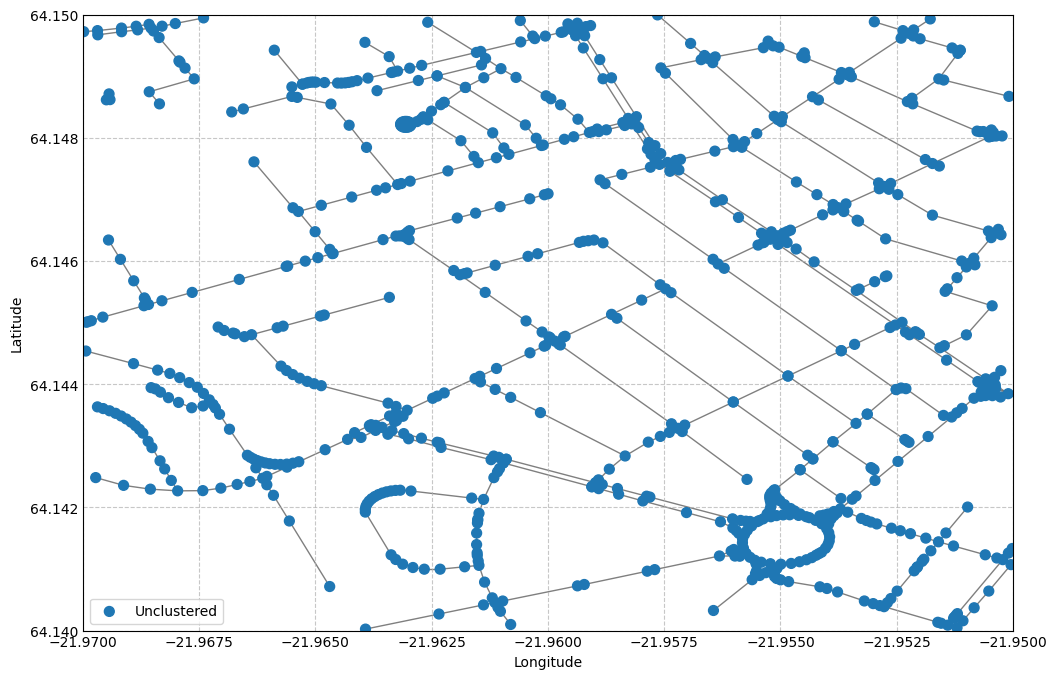

In [11]:
plot_node_graph(G, xlim=(x_min, x_max), ylim=(y_min, y_max))

In [12]:
def clean_up(G: nx.Graph) -> nx.Graph:
    nodes_to_remove = [node for node, data in G.nodes(data=True) if len(data['turns']) > 2 and np.all(
        np.logical_not(list(data['turns'].values())))]
    print(f'Number of nodes with no turns = {nodes_to_remove}')

    G.remove_nodes_from(nodes_to_remove)
    print(f'{len(list(nx.connected_components(G))) = }')
    print(f'{min(list(map(len, nx.connected_components(G)))) = }')

    # Extract all connected components from the graph
    connected_components = nx.connected_components(G)

    # Filter components based on their size
    large_components = [cc for cc in connected_components if len(cc) > 100]

    # Combine all large components into a single subgraph
    # This will include all nodes and edges from the components with size > 100
    G = G.subgraph(set.union(*map(set, large_components))).copy()

    print(f'{len(list(nx.connected_components(G))) = }')
    print(f'{min(list(map(len, nx.connected_components(G)))) = }')
    remove_deleted_turns(G)

    print(
        f'Current size: {G.number_of_nodes()} nodes, {G.number_of_nodes()} edges')

    return G


def clean_up_cycle(G: nx.Graph) -> nx.Graph:
    remove_deleted_turns(G)
    nodes_n, edges_n = G.number_of_nodes(), G.number_of_edges()
    print(f'Original size: {nodes_n} nodes, {edges_n} edges')
    G = clean_up(G)
    while G.number_of_nodes() != nodes_n or G.number_of_edges() != edges_n:
        nodes_n, edges_n = G.number_of_nodes(), G.number_of_edges()
        G = clean_up(G)
    G = clean_up(G)

    return G

In [13]:
print_graph_info(G)

Undirected has 63979 nodes and 64344 edges
+----------------------+
Nodes
+----------------------+
*** Node: 12339218092 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218091, 12339218093): True}}
*** Node: 12339218098 ***
  Data: {'coord': <POINT (-21.938 64.068)>, 'turns': {(12339218091, 12339218099): True}}
*** Node: 12339218091 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218092, 12339218098): True, (12339218092, 12339218194): True, (12339218098, 12339218194): True}}
*** Node: 12339218194 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218091, 12339218193): True}}
*** Node: 12339218093 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218092, 12339218094): True}}
*** Node: 12339218094 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218093, 12339218095): True}}
+----------------------+
Edges
+----------------------+
*** Edge: 12339218092 -> 12339218091 ***
  Data: {}
*** Edge: 12339218092 -> 1233921809

In [14]:
G = clean_up_cycle(G)

Original size: 63979 nodes, 64344 edges
Number of nodes with no turns = [12339275847]
len(list(nx.connected_components(G))) = 1130
min(list(map(len, nx.connected_components(G)))) = 3
len(list(nx.connected_components(G))) = 30
min(list(map(len, nx.connected_components(G)))) = 107
Current size: 53349 nodes, 53349 edges
Number of nodes with no turns = []
len(list(nx.connected_components(G))) = 30
min(list(map(len, nx.connected_components(G)))) = 107
len(list(nx.connected_components(G))) = 30
min(list(map(len, nx.connected_components(G)))) = 107
Current size: 53349 nodes, 53349 edges
Number of nodes with no turns = []
len(list(nx.connected_components(G))) = 30
min(list(map(len, nx.connected_components(G)))) = 107
len(list(nx.connected_components(G))) = 30
min(list(map(len, nx.connected_components(G)))) = 107
Current size: 53349 nodes, 53349 edges


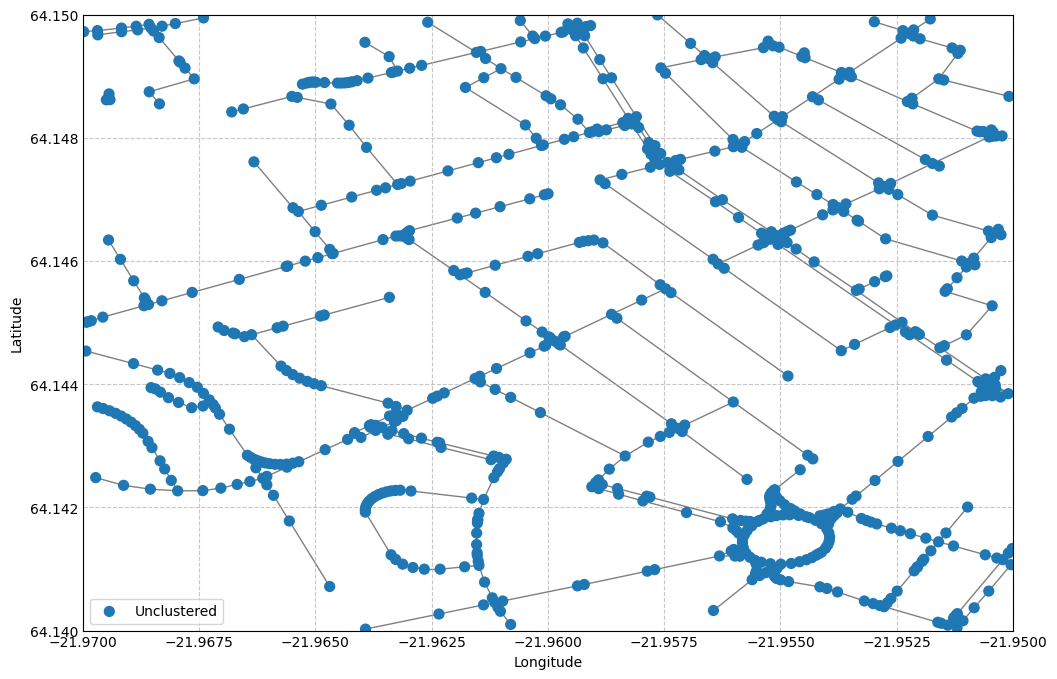

In [15]:
plot_node_graph(G, xlim=(x_min, x_max), ylim=(y_min, y_max))

In [16]:
# plot_node_graph(G, xlim=(-21.96, -21.9575),
#                 ylim=(64.146, 64.148), show_node_ids=True)

In [17]:
node_id = 12339220696

print(G.nodes[node_id])
print(list(G.neighbors(node_id)))

{'coord': <POINT (-21.958 64.147)>, 'turns': {(12339220565, 12339220697): True}}
[12339220565, 12339220697]


In [18]:
# # Find the largest connected component
# largest_cc = max(nx.connected_components(G), key=len)

# # Create a subgraph with only the largest connected component
# G = G.subgraph(largest_cc).copy()

In [19]:
print_graph_info(G)

Undirected has 53349 nodes and 54581 edges
+----------------------+
Nodes
+----------------------+
*** Node: 12339218092 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218091, 12339218093): True}}
*** Node: 12339218098 ***
  Data: {'coord': <POINT (-21.938 64.068)>, 'turns': {(12339218091, 12339218099): True}}
*** Node: 12339218091 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218092, 12339218098): True, (12339218092, 12339218194): True, (12339218098, 12339218194): True}}
*** Node: 12339218194 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218091, 12339218193): True}}
*** Node: 12339218093 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218092, 12339218094): True}}
*** Node: 12339218094 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218093, 12339218095): True}}
+----------------------+
Edges
+----------------------+
*** Edge: 12339218092 -> 12339218091 ***
  Data: {}
*** Edge: 12339218092 -> 1233921809

In [20]:
# plot_node_graph(G)

In [21]:
G.degree()

DegreeView({12339218092: 2, 12339218098: 2, 12339218091: 3, 12339218194: 2, 12339218093: 2, 12339218094: 2, 12339218095: 2, 12339218096: 2, 12339218097: 3, 12339218111: 2, 12339267993: 2, 12339218099: 2, 12339218100: 2, 12339218101: 2, 12339218102: 3, 12339267973: 2, 12339267984: 2, 12339218104: 2, 12339218107: 2, 12339218103: 3, 12339218201: 2, 12339218105: 2, 12339218106: 3, 12339225591: 2, 12339268135: 2, 12339218108: 2, 12339218109: 2, 12339218110: 2, 12339218143: 2, 12339218112: 3, 12339218178: 2, 12339218188: 2, 12339218114: 2, 12339218190: 2, 12339218113: 3, 12339266366: 2, 12339218115: 3, 12339218145: 2, 12339218158: 2, 12339218117: 2, 12339218124: 2, 12339218116: 2, 12339218118: 2, 12339218119: 2, 12339218120: 2, 12339218121: 2, 12339218122: 2, 12339218123: 1, 12339218125: 2, 12339218126: 2, 12339218127: 3, 12339218197: 2, 12339232220: 2, 12339218129: 2, 12339218138: 2, 12339218128: 3, 12339218140: 2, 12339218130: 2, 12339218131: 2, 12339218132: 2, 12339218133: 2, 12339218134:

In [22]:
interesting_node = [node for node, degree in G.degree() if degree > 2][0]
print(interesting_node)

12339218091


In [23]:
display(G.nodes[interesting_node])
print(f'{G.nodes(data=True)[interesting_node] = }')
print(G.degree(interesting_node))
print(list(G.neighbors(interesting_node)))

{'coord': <POINT (-21.937 64.067)>,
 'turns': {(12339218092, 12339218098): True,
  (12339218092, 12339218194): True,
  (12339218098, 12339218194): True}}

G.nodes(data=True)[interesting_node] = {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218092, 12339218098): True, (12339218092, 12339218194): True, (12339218098, 12339218194): True}}
3
[12339218092, 12339218098, 12339218194]


In [24]:
G = add_cluster_attribute_connected_components(G)

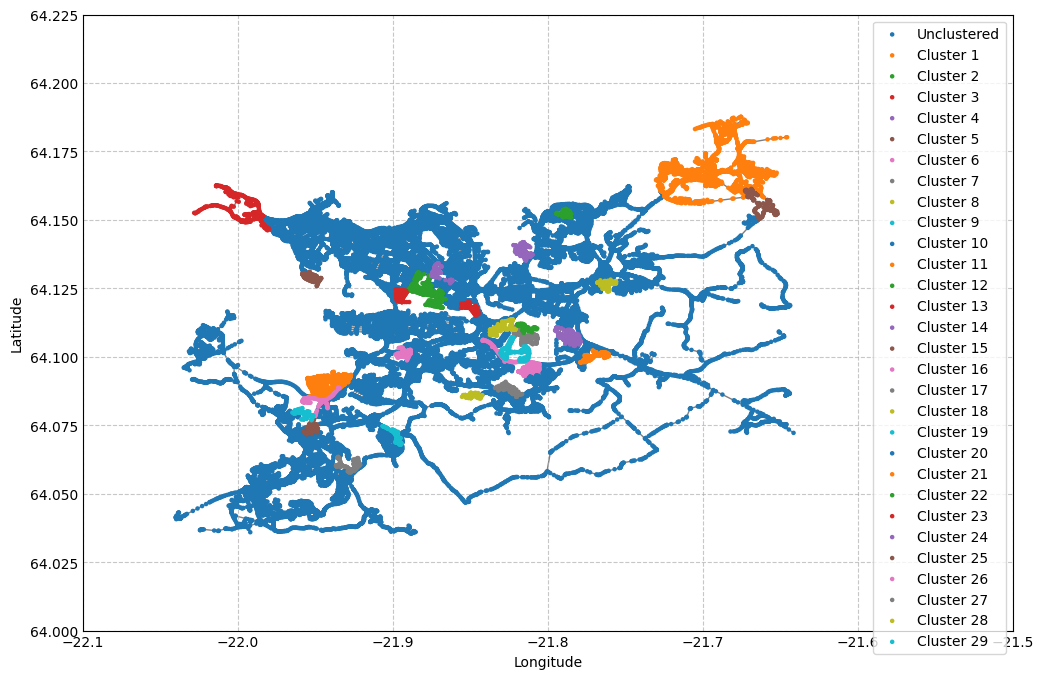

In [25]:
plot_node_graph(G, cluster_attribute="cluster",
                show_node_ids=False, show_nodes_labels=False, node_size=5)

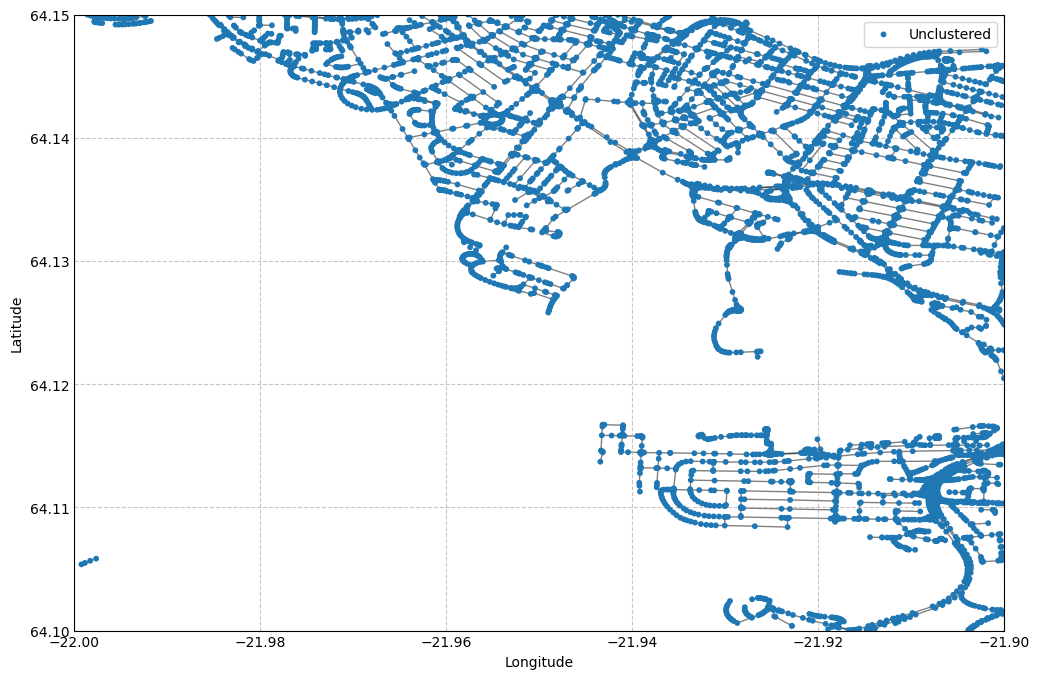

In [26]:
plot_node_graph(G, xlim=(-22, -21.9), ylim=(64.1, 64.150),
                show_node_ids=False, show_nodes_labels=False, node_size=10)

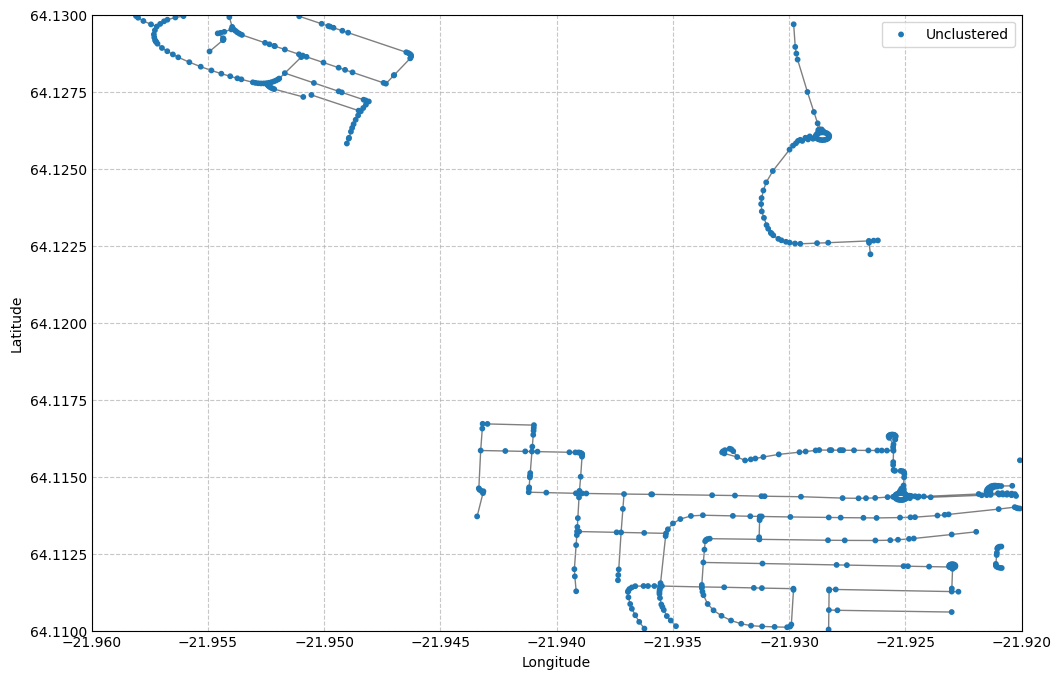

In [27]:
plot_node_graph(G, xlim=(-21.96, -21.92), ylim=(64.11, 64.13),
                show_node_ids=False, show_nodes_labels=False, node_size=10)

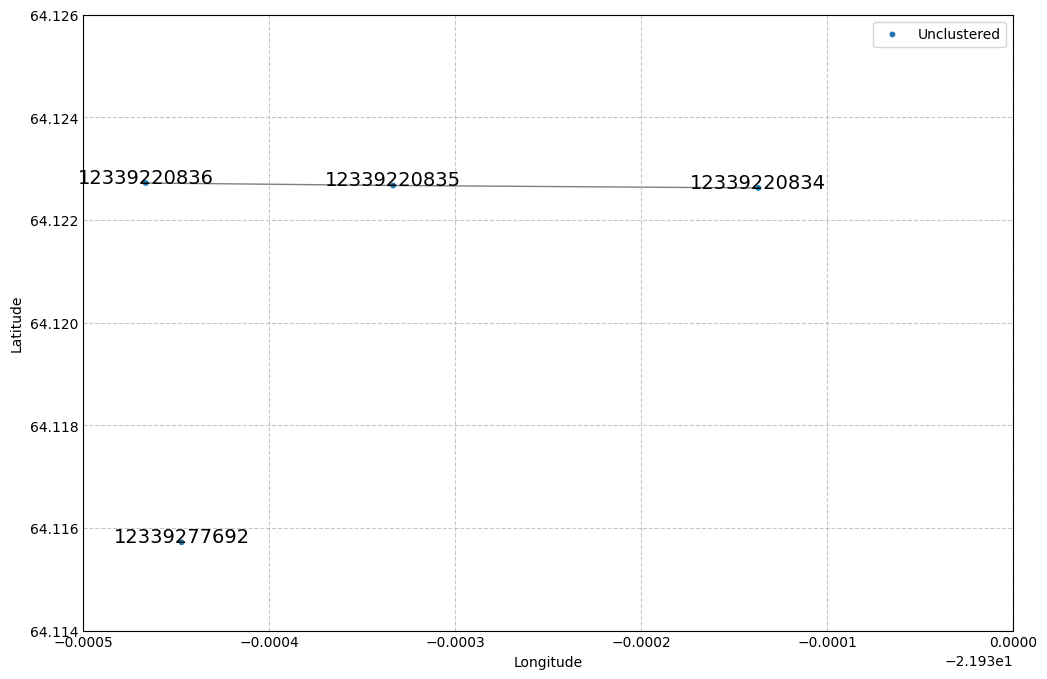

In [28]:
plot_node_graph(G, xlim=(-21.9305, -21.93), ylim=(64.115, 64.125),
                show_node_ids=True, show_nodes_labels=False, node_size=10)

In [29]:
G = add_edge_and_allow_turns(G, 12339277692, 12339220836)

Edge added between 12339277692 and 12339220836 with all turns allowed.


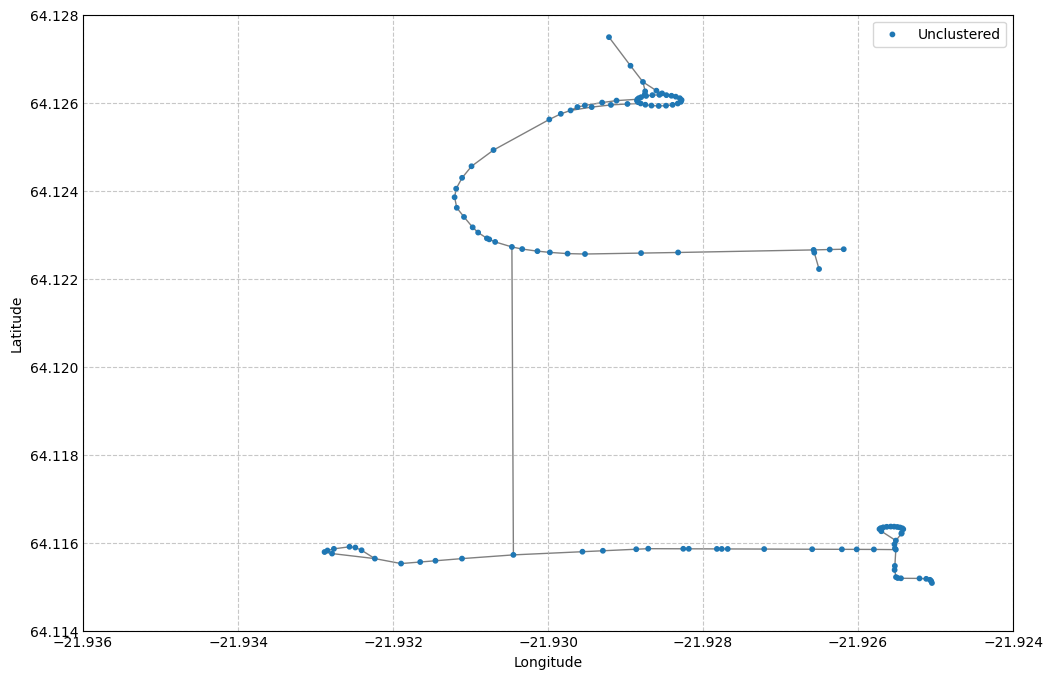

In [30]:

-21.935, -21.925, 64.115, 64.1275
plot_node_graph(G, xlim=(-21.935, -21.925), ylim=(64.115, 64.1275),
                show_node_ids=False, show_nodes_labels=False, node_size=10)

In [31]:
G = allow_all_turns_for_nodes(
    G, find_nodes_in_bounds(G, -21.935, -21.925, 64.115, 64.1275))

All turns allowed for nodes: [12339220826, 12339220828, 12339220827, 12339220829, 12339220852, 12339220830, 12339220831, 12339220832, 12339220833, 12339220834, 12339220835, 12339220836, 12339220837, 12339220838, 12339220839, 12339220840, 12339220841, 12339220842, 12339220843, 12339220844, 12339220845, 12339220846, 12339220847, 12339220848, 12339220849, 12339220850, 12339220851, 12339238996, 12339238992, 12339220853, 12339238981, 12339238984, 12339238980, 12339274805, 12339238982, 12339238983, 12339244235, 12339244237, 12339238985, 12339238986, 12339238987, 12339238999, 12339244236, 12339238989, 12339238993, 12339238988, 12339238990, 12339238991, 12339238994, 12339238995, 12339274795, 12339238998, 12339238997, 12339244238, 12339274796, 12339274797, 12339274798, 12339274799, 12339274800, 12339274801, 12339274802, 12339274803, 12339274804, 12339276228, 12339276240, 12339276227, 12339276241, 12339276229, 12339276230, 12339276231, 12339276232, 12339276233, 12339276234, 12339276235, 12339276

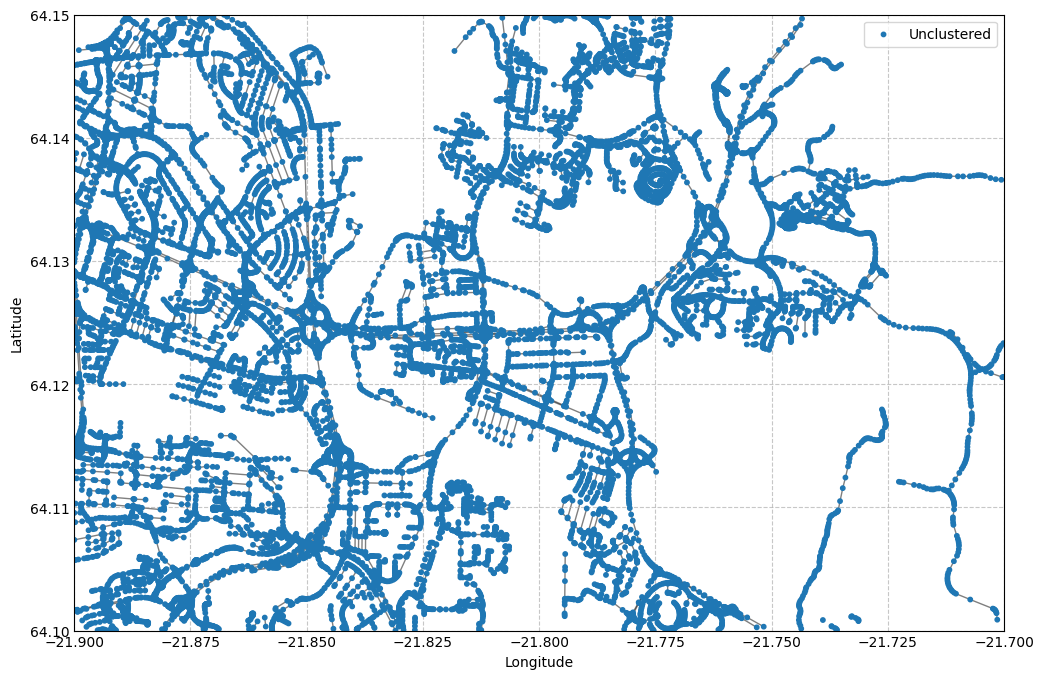

In [32]:
plot_node_graph(G, xlim=(-21.9, -21.7), ylim=(64.1, 64.150),
                show_node_ids=False, show_nodes_labels=False, node_size=10)

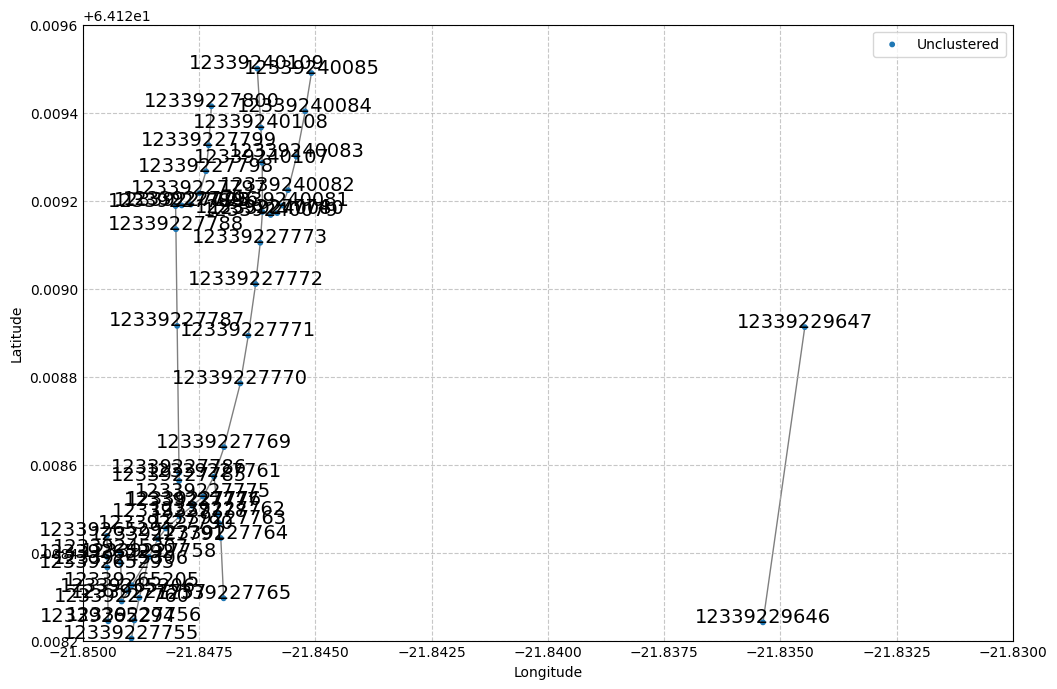

In [33]:
plot_node_graph(G, xlim=(-21.85, -21.83), ylim=(64.1282, 64.1295),
                show_node_ids=True, show_nodes_labels=False, node_size=10)

In [34]:
add_edge_and_allow_turns(G, 12339227771, 12339229647)

Edge added between 12339227771 and 12339229647 with all turns allowed.


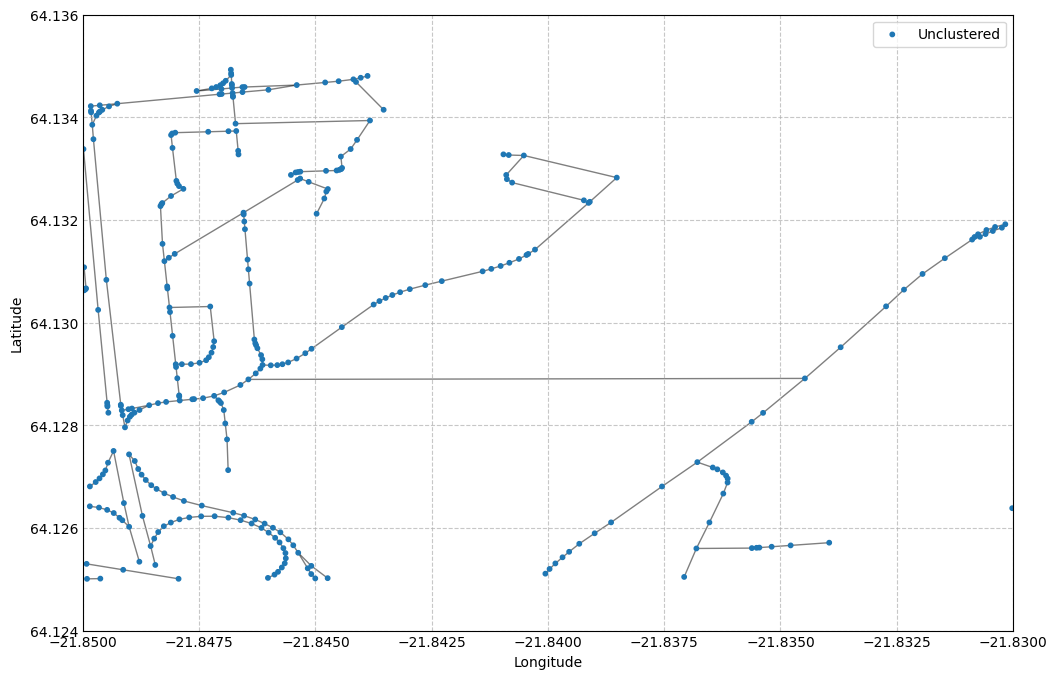

In [35]:
plot_node_graph(G, xlim=(-21.85, -21.83), ylim=(64.125, 64.135),
                show_node_ids=False, show_nodes_labels=False, node_size=10)

In [36]:
allow_all_turns_for_nodes(G, find_nodes_in_bounds(
    G, -21.85, -21.83, 64.125, 64.135))

All turns allowed for nodes: [12339224687, 12339219664, 12339219680, 12339219663, 12339219665, 12339219666, 12339219667, 12339219668, 12339219669, 12339219681, 12339224721, 12339224719, 12339223522, 12339223523, 12339223524, 12339223525, 12339238505, 12339224654, 12339224655, 12339224656, 12339224686, 12339224714, 12339224715, 12339224716, 12339224717, 12339224718, 12339224731, 12339224732, 12339224733, 12339224734, 12339224735, 12339257423, 12339224736, 12339224737, 12339224738, 12339224739, 12339224740, 12339224741, 12339224742, 12339224743, 12339224744, 12339224745, 12339224746, 12339224747, 12339224748, 12339224749, 12339224750, 12339224751, 12339224752, 12339224753, 12339225828, 12339225800, 12339225799, 12339225801, 12339225802, 12339225803, 12339225804, 12339225805, 12339225806, 12339225807, 12339225808, 12339225809, 12339225810, 12339225811, 12339225812, 12339225813, 12339225814, 12339225815, 12339225816, 12339225817, 12339225818, 12339225819, 12339225820, 12339225821, 12339225

In [37]:
save_graph(G, '../data/final_node_graph.json')